In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
%matplotlib inline
np.random.seed(0)
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
sns.set_theme(context="notebook")

In [110]:
s80 = pd.read_csv('selection_80_df.csv')
test = pd.read_csv('./test.csv')
dT = pd.read_csv('./train.csv')
dT.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1


In [112]:
# train = dT.dropna().copy()
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import QuantileTransformer,  KBinsDiscretizer

X_test = test.copy()
X = dT.drop('claim',axis=1).copy()

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imp.fit_transform(X)
X_test = imp.transform(X_test)
qt = QuantileTransformer(n_quantiles=150, output_distribution='uniform')
X = qt.fit_transform(X)
X_test = qt.transform(X_test)
bin_cat = KBinsDiscretizer(n_bins=1200, encode='ordinal',strategy='uniform')
X = bin_cat.fit_transform(X)
X_test = bin_cat.transform(X_test)


y = dT['claim'].copy()
# print(X.isnull().sum())
# train = train[list(s80.loc[0:80,'Feature'])]
# X = train.copy()
# X.head()
print(X)

AttributeError: 'numpy.ndarray' object has no attribute 'isnull'

In [114]:
from sklearn.model_selection import train_test_split
# X = X[feats[0:int(len(feats)/2)]]
X_go = X.copy()
scaler = MinMaxScaler()
scaler.fit(X_go)
X_go = scaler.transform(X_go)
y_go = y
X_train, X_valid, y_train, y_valid = train_test_split(X_go, y_go, test_size=0.33, random_state=42)
print(X_train)

[[0.07673061 0.25354462 0.97164304 ... 0.22268557 0.58381985 0.17597998]
 [0.57547957 0.63219349 0.91159299 ... 0.52126772 0.74228524 0.16930776]
 [0.58798999 0.86405338 0.92243536 ... 0.14178482 0.66805671 0.69224354]
 ...
 [0.13678065 0.07673061 0.96580484 ... 0.67389491 0.44036697 0.53544621]
 [0.70058382 0.37030859 0.08006672 ... 0.83736447 0.89074229 0.10842369]
 [0.12677231 0.37864887 0.72560467 ... 0.31359466 0.68890742 0.65387823]]


In [115]:
print(y_train.shape)
print(X_train.shape)
print(y_valid.shape)
print(X_valid.shape)
print([y_train.shape[0]])
print(y_valid)

(641805,)
(641805, 119)
(316114,)
(316114, 119)
[641805]
682721    0
470979    1
394613    1
329967    0
711757    0
         ..
443252    1
169305    0
953987    0
739397    1
829320    1
Name: claim, Length: 316114, dtype: int64


In [129]:
from xgboost import XGBClassifier
# from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import cross_validate
import warnings 

warnings.filterwarnings('ignore')

seed = 0
fold = 5

model_xgb = XGBClassifier(
    max_depth=8,
    subsample=.75,
    colsample_bytree=.5,
    reg_lambda=8,
    gamma=2,
    tree_method='gpu_hist',
    sampling_method='gradient_based', 
    random_state= seed,
)
def score(X, y, model_xgb, cv):
    scoring = ["roc_auc"]
    scores = cross_validate(
        model_xgb, X, y, scoring=scoring, cv=cv, return_train_score=True
    )
    scores = pd.DataFrame(scores).T
    return scores.assign(
        mean = lambda x: x.mean(axis=1),
        std = lambda x: x.std(axis=1),
    )

model_xgb.fit(X_train,y_train)
scores = score(X_valid, y_valid, model_xgb, cv=fold)
print(scores)
# plot_importance(model_xgb)

[18:12:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,0,1,2,3,4,mean,std
fit_time,8.831147,8.595001,8.486043,8.457224,8.505308,8.574945,0.136127
score_time,0.144956,0.139001,0.113313,0.152133,0.124997,0.134880,0.013993
test_roc_auc,0.736529,0.737607,0.735349,0.739011,0.737797,0.737259,0.001238
train_roc_auc,0.909130,0.908861,0.907968,0.906599,0.907303,0.907972,0.000945


In [119]:
print(X.shape)

(957919, 119)


In [120]:
X[:,-1]=  model_xgb.predict(X)
# print(X.columns)

In [ ]:
# X_go = X.copy()
# scaler = MinMaxScaler()
# scaler.fit(X_go)
# X_go = scaler.transform(X_go)
# y_go = y
# X_train, X_valid, y_train, y_valid = train_test_split(X_go, y_go, test_size=0.33, random_state=42)
# print(X_train)
# print(y_train.shape)
# print(X_train.shape)
# print(y_valid.shape)
# print(X_valid.shape)
# print([y_train.shape[0]])
# print(y_valid)

[[0.64056483 0.16876908 0.17531881 ... 0.10047221 0.04411548 0.        ]
 [0.6534018  0.18812271 0.05450027 ... 0.35725495 0.14377085 0.        ]
 [0.67907574 0.40343746 0.02221769 ... 0.01470174 0.51127346 0.        ]
 ...
 [0.46598203 0.24265911 0.19282309 ... 0.029133   0.5258423  0.        ]
 [0.79460847 0.26110844 0.22250688 ... 0.01378369 0.27148447 0.        ]
 [0.32477535 0.16633699 0.07665736 ... 0.09574298 0.49879216 0.        ]]
(240840,)
(240840, 44)
(118624,)
(118624, 44)
[240840]
735464    0
789188    0
905701    0
364966    0
802402    0
         ..
46658     1
236434    0
223597    0
477107    1
819708    0
Name: claim, Length: 118624, dtype: int64


In [121]:
from tensorflow import keras
from tensorflow.keras import layers

input_shape= [X_train.shape[1]]
print(input_shape)

model = keras.Sequential([
    layers.Input(input_shape),
    # layers.BatchNormalization(input_shape=input_shape),
    # layers.Dropout(rate = 0.3),
    layers.Embedding (input_dim=1200, output_dim=64),
    layers.Flatten(),
    layers.Dropout(0.3),
    # layers.Dense(100, activation='sigmoid'),
    layers.Dense(42, kernel_initializer=keras.initializers.GlorotNormal(), activation='swish'),
    # layers.Dense(100, activation='sigmoid'),
    # layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.5),
    layers.Dense(1, activation='sigmoid')
])

# rmsprop = keras.optimizers.RMSprop(
#     learning_rate=0.001,
#     rho=0.9,
#     momentum=0.0,
#     epsilon=1e-07,
#     centered=False,
#     name="RMSprop"
# )

metrica = keras.metrics.AUC(
    num_thresholds=5, curve='ROC',
    summation_method='interpolation', name='auc', dtype=None,
    thresholds=None, multi_label=False, num_labels=None, label_weights=None,
    from_logits=False
)

# keras.optimizers.Adam()
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    loss = 'binary_crossentropy',
    metrics = [metrica]
)

model.summary()
from tensorflow.keras import callbacks

guardaDeTransito = callbacks.EarlyStopping(
    patience=15,
    min_delta=0.0001,
    restore_best_weights = True
)

[119]
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 119, 64)           76800     
_________________________________________________________________
flatten_3 (Flatten)          (None, 7616)              0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 7616)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 42)                319914    
_________________________________________________________________
batch_normalization_14 (Batc (None, 42)                168       
_________________________________________________________________
dropout_18 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)         

In [123]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=1024,
    epochs=10,
    verbose=1,
    callbacks=[guardaDeTransito]
)

Epoch 1/10
627/627 [==============================] - 75s 120ms/step - loss: 0.6938 - auc: 0.5007 - val_loss: 0.6932 - val_auc: 0.5001
Epoch 2/10
627/627 [==============================] - 76s 121ms/step - loss: 0.6935 - auc: 0.5010 - val_loss: 0.6933 - val_auc: 0.5004
Epoch 3/10
 99/627 [===>..........................] - ETA: 57s - loss: 0.6933 - auc: 0.5018

KeyboardInterrupt: 

In [104]:
# def scoreNormal(X, y, model, cv):
#     scoring = ["roc_auc"]
#     scores = cross_validate(
#         model, X, y, scoring=scoring, cv=cv, return_train_score=True
#     )
#     scores = pd.DataFrame(scores).T
#     return scores.assign(
#         mean = lambda x: x.mean(axis=1),
#         std = lambda x: x.std(axis=1),
#     )

# scores = scoreNormal(X_valid,y_valid,model,cv = fold)
# print(scores)

<AxesSubplot:title={'center':'Accuracy'}>

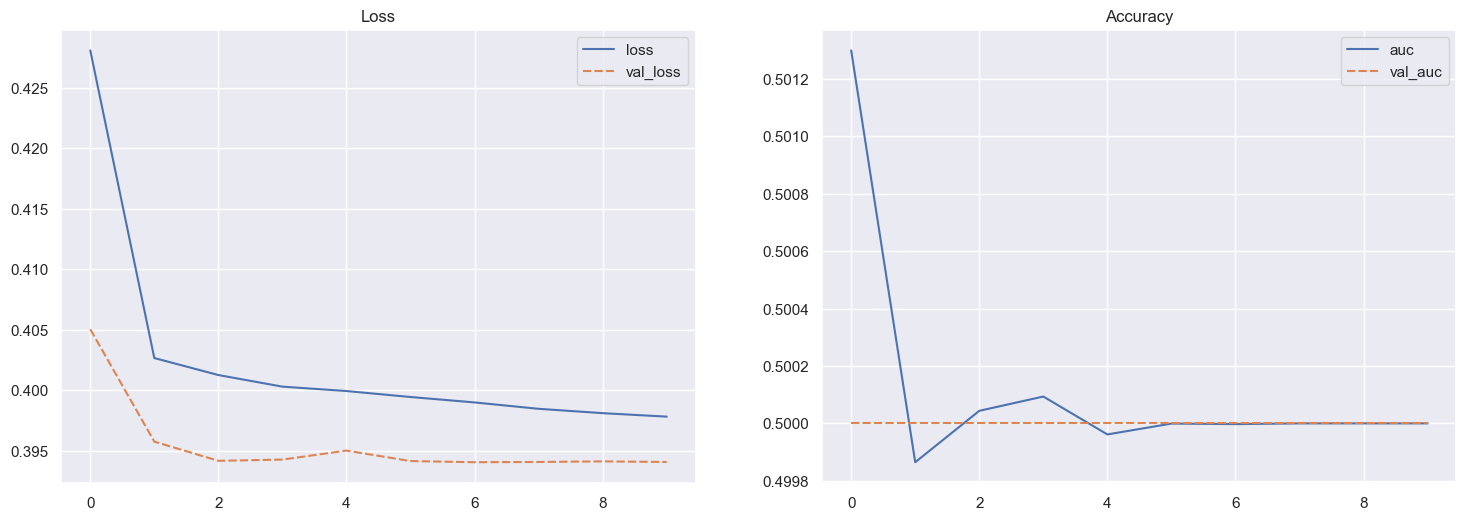

In [ ]:
historyd = pd.DataFrame(history.history)
fig, axs = plt.subplots(1,2, figsize = (18,6))

axs[0].set_title('Loss')
sns.lineplot(data = historyd.loc[:,['loss', 'val_loss']], ax = axs[0])

axs[1].set_title('Accuracy')
sns.lineplot(data = historyd.loc[:,['auc', 'val_auc']], ax = axs[1])

In [105]:
feats = X.columns
print(feats)
tests = test[feats]
tests[feats].head()


Index(['f97', 'f96', 'f95', 'f92', 'f87', 'f82', 'f8', 'f79', 'f73', 'f71',
       'f68', 'f63', 'f62', 'f57', 'f52', 'f50', 'f48', 'f47', 'f46', 'f45',
       'f44', 'f38', 'f36', 'f35', 'f34', 'f32', 'f31', 'f30', 'f3', 'f24',
       'f23', 'f21', 'f15', 'f13', 'f113', 'f107', 'f106', 'f104', 'f102',
       'f1', 'f9', 'f89', 'f86', 'xg_out'],
      dtype='object')


KeyError: "['xg_out'] not in index"

In [125]:
test.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
0,957919,0.165850,0.487050,1295.00,0.02310,0.31900,0.90188,573.29,3743.7,2.705700e+12,...,0.16253,-22.1890,2.0655,0.430880,-10.7410,81606.0,1.1940,1.980400e+14,2017.1,0.46357
1,957920,0.129650,0.373480,1763.00,0.72884,0.33247,-1.26310,875.55,554370.0,5.955700e+14,...,0.81528,-1.6342,1.5736,-1.071200,11.8320,90114.0,1.1507,4.388000e+16,6638.9,0.28125
2,957921,0.120190,0.445210,736.26,0.04615,0.29605,0.31665,2659.50,317140.0,3.977800e+14,...,0.81831,-32.7800,2.1364,-1.931200,-3.2804,37739.0,1.1548,1.718100e+14,5844.0,0.13797
3,957922,0.054008,0.395960,996.14,0.85934,0.36678,-0.17060,386.56,325680.0,-3.432200e+13,...,0.86559,-2.4162,1.5199,-0.011633,1.3840,26849.0,1.1490,2.138800e+17,6173.3,0.32910
4,957923,0.079947,-0.006919,10574.00,0.34845,0.45008,-1.84200,3027.00,428150.0,9.291500e+11,...,0.25190,-18.6300,3.7387,0.757080,-4.9405,50336.0,1.2488,2.151300e+17,2250.1,0.33796


id       1.204656e+08
claim    6.744671e+01
dtype: float64


<AxesSubplot:>

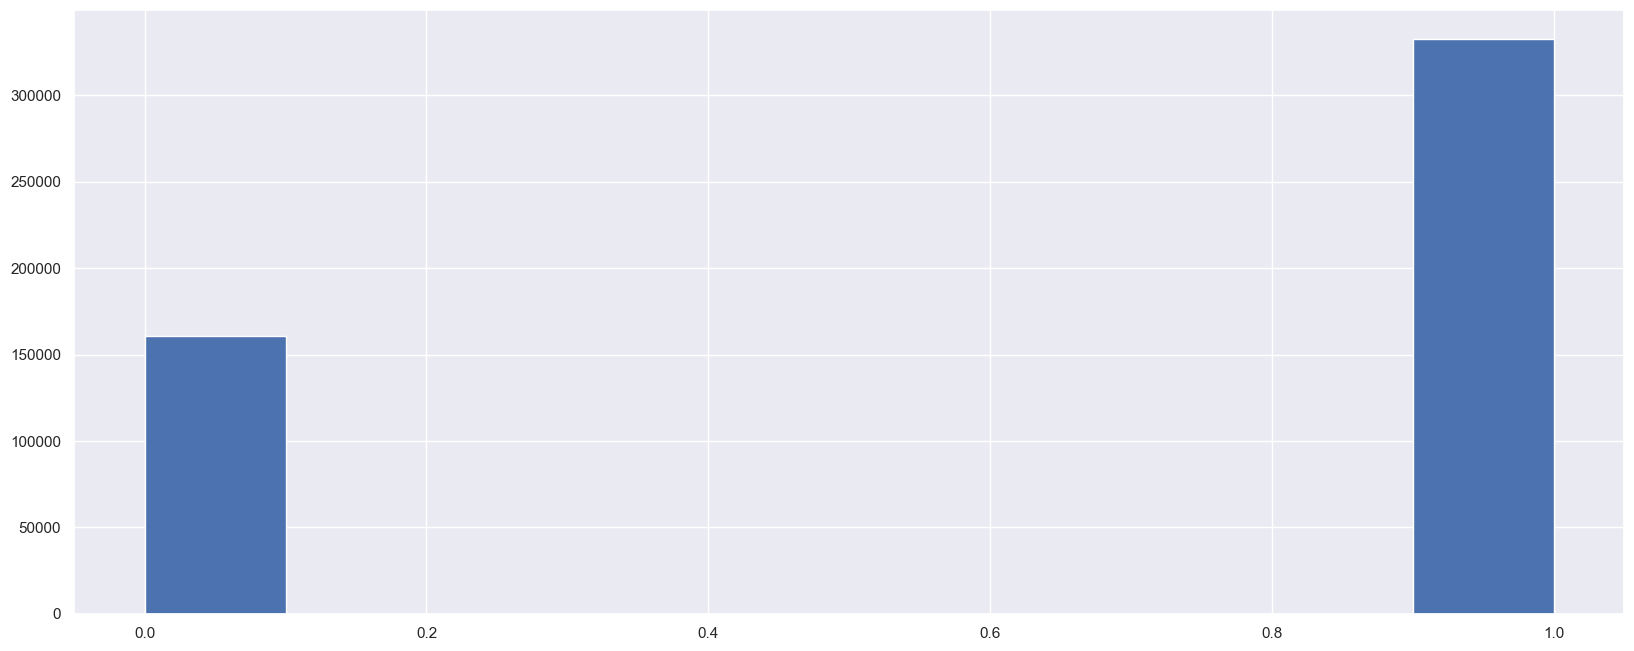

In [130]:
# tests['xg'] = model_xgb.predict(tests)
sub = model_xgb.predict(test)
mysub = pd.DataFrame(test['id'])
mysub['claim'] = sub
mysub['claim'] = mysub['claim'].fillna(0)
print(mysub.mean()*100)
mysub['claim'].hist()

In [131]:
# sub = model.predict(test[feats])
# mysub = pd.DataFrame(test['id'])
# mysub['claim'] = sub
# mysub['claim'] = mysub['claim'].fillna(0)
# mysub.head(10)
print(test.shape)
print(mysub.shape)
print(mysub.isnull().sum())
# sub = sub.drop(0,axis=1)
# print(sub.isnull().sum())
mysub.head()

(493474, 119)
(493474, 2)
id       0
claim    0
dtype: int64


,id,claim
0,957919,0
1,957920,1
2,957921,1
3,957922,1
4,957923,1


In [128]:
var = 'xgboost_COM_eda_daNN_ALLf'
mysub.to_csv(var+'_submisssion.csv',index=False)